In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

In [94]:
train=pd.read_csv('../../../../Data/train.csv',parse_dates=['MMM-YY','Dateofjoining','LastWorkingDate'])
test=pd.read_csv('../../../../Data/test.csv')
train.shape, test.shape

((19104, 13), (741, 1))

Text(0.5, 1.0, 'Histogram of No. of months worked before leaving')

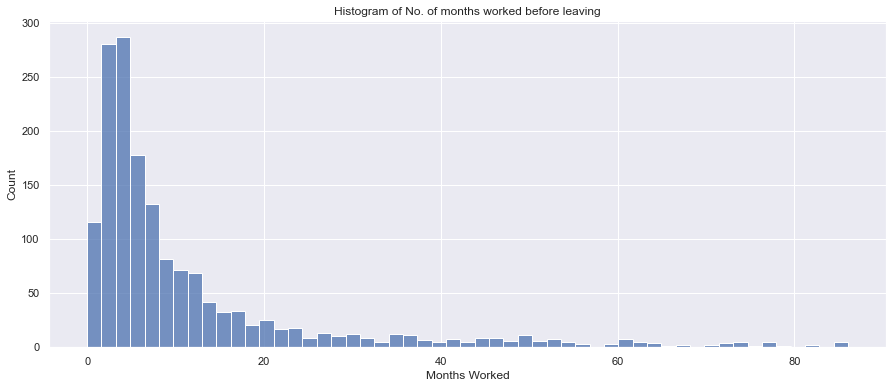

In [95]:
def func(sub):
    return pd.Series([(sub['LastWorkingDate'].iloc[-1]-sub['Dateofjoining'].iloc[-1]).days/30,
                      (sub['MMM-YY'].iloc[-1]-sub['Dateofjoining'].iloc[-1]).days/30])
df=train.groupby(['Emp_ID']).apply(func).reset_index()
df.columns=['EMp_ID','Months Worked','Months Since Joined']
sns.set(rc={'figure.figsize':(15,6)})
sns.histplot(data=df.dropna(),x='Months Worked').set_title('Histogram of No. of months worked before leaving')

* Employees usually leave the organization within the first year

Text(0.5, 1.0, 'Average Tenure by City and Education Level')

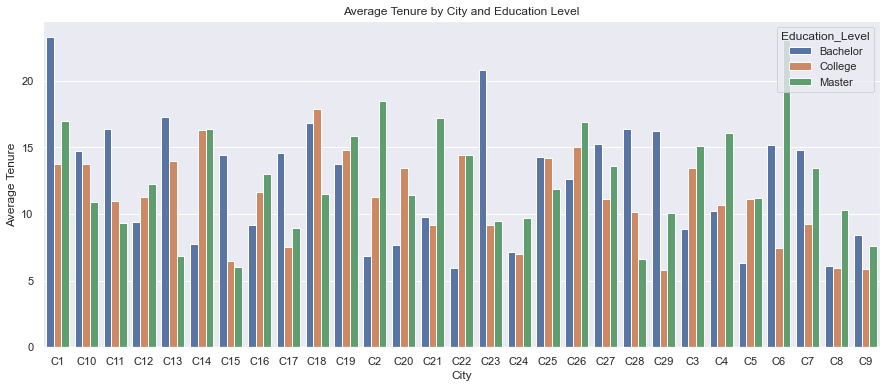

In [96]:
df=train.groupby(['Education_Level','City']).apply(lambda x:np.nanmean((x['LastWorkingDate']-x['Dateofjoining']).dt.days)/30).reset_index()
df.columns=[*df.columns[:-1]]+['Average Tenure']
sns.barplot(data=df,x='City',y='Average Tenure',hue='Education_Level').set_title('Average Tenure by City and Education Level')

* In cities C1,C11,C13,C23,C27,C28 and C29, employees with Bachelor education level on an average stay longest with a miniumum tenure of 15 months
* In cities C19,C2,C21,C26,C3,C4 and C6, employees with Master education level on an average stay longest with a miniumum tenure of 15 months

In [97]:
df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:np.nanmean((x['LastWorkingDate']-x['Dateofjoining']).dt.days)/30).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCityTenure']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:x['Salary'].mean()).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCitySalary']
train=pd.merge(train,df)
train['avgSalDiff']=train['Salary']-train['avgEduGenCitySalary']

df=train.groupby(['Education_Level','Gender','City']).apply(lambda x:x['Age'].mean()).reset_index()
df.columns=[*df.columns[:-1]]+['avgEduGenCityAge']
train=pd.merge(train,df)
train['avgAgeDiff']=train['Salary']-train['avgEduGenCityAge']

df=train.groupby(['Education_Level','City']).apply(lambda x:sum(x['Gender']=='Female')/len(x)).reset_index()
df.columns=[*df.columns[:-1]]+['femaleRatio']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','City']).apply(lambda x:np.mean(x['Age'][x['Gender']=='Female'])).reset_index()
df.columns=[*df.columns[:-1]]+['avgFemaleAge']
train=pd.merge(train,df)

df=train.groupby(['Education_Level','City']).apply(lambda x:np.mean(x['Age'][x['Gender']=='Male'])).reset_index()
df.columns=[*df.columns[:-1]]+['avgMaleAge']
train=pd.merge(train,df)

In [99]:
def preprocess(sub):
    sub['LastWorkingDate']=sub['LastWorkingDate'].iloc[-1]
    sub['monthsSinceJoined']=((sub['MMM-YY']-sub['Dateofjoining']).dt.days)/30
    sub['changeInSal']=(sub['Salary']-sub['Salary'].iloc[0])/sub['Salary'].iloc[0]
    sub['changeInDesig']=sub['Joining Designation']-sub['Joining Designation'].shift(1)
    sub['changeInDesigFromInitial']=sub['Designation']-sub['Joining Designation']
    sub['monthlyNet']=(sub['Total Business Value']-sub['Salary'])/sub['Salary']
    sub['prevQuatRate']=sub['Quarterly Rating'].shift(1)
    sub['quatRateDiff']=sub['Quarterly Rating']-sub['prevQuatRate']
    sub['cumSalary']=sub['Salary'].cumsum()
    sub['cumTotBusValue']=sub['Total Business Value'].cumsum()
    sub['meanQuatRate']=sub['Quarterly Rating'].expanding().mean()
    sub['cumNet']=(sub['cumTotBusValue']-sub['cumSalary'])/sub['cumSalary']
    sub['meanCumNet']=sub['cumNet'].expanding().mean()
    
    t=np.where(sub['Salary']-sub['Salary'].shift(1)>0)[0]
    if len(t==1):
        sub['timeSinceSalChange']=np.concatenate((np.tile(0,t),np.arange(1,len(sub)-t+1)))
    else:
        sub['timeSinceSalChange']=0
    return sub

train=train.groupby('Emp_ID').apply(preprocess)
train['target']=(((train['LastWorkingDate']-train['MMM-YY']).dt.days)<180)*1 # under next 180 days one will left companu
train['target'].fillna(0,inplace=True)

In [100]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating',
       'avgEduGenCityTenure', 'avgEduGenCitySalary', 'avgSalDiff',
       'avgEduGenCityAge', 'avgAgeDiff', 'femaleRatio', 'avgFemaleAge',
       'avgMaleAge', 'monthsSinceJoined', 'changeInSal', 'changeInDesig',
       'changeInDesigFromInitial', 'monthlyNet', 'prevQuatRate',
       'quatRateDiff', 'cumSalary', 'cumTotBusValue', 'meanQuatRate', 'cumNet',
       'meanCumNet', 'timeSinceSalChange', 'target'],
      dtype='object')

In [101]:
train.groupby('Emp_ID').last().target.value_counts()

1    1616
0     765
Name: target, dtype: int64

In [102]:
# train

In [103]:
np.sum(train[['Age','Gender','Emp_ID','City','Education_Level','Salary','Dateofjoining','Joining Designation','Designation','Quarterly Rating']].groupby('Emp_ID').nunique().reset_index()!=1)

Emp_ID                 2380
Age                    1087
Gender                    0
City                      0
Education_Level           0
Salary                   44
Dateofjoining             0
Joining Designation       0
Designation              44
Quarterly Rating       1104
dtype: int64

* Gender, City, Education_Level, Dateofjoining,Joining Designation contain only 1 value per employee as expected

In [104]:
train_v2 = train.copy()

In [105]:
test=train[(train['Emp_ID'].isin(test['Emp_ID'])) & (train['MMM-YY']==pd.to_datetime('2017-12-01',format='%Y-%m-%d'))]
train=train[train['MMM-YY']<pd.to_datetime('2017-08-01',format='%Y-%m-%d')]
print (train.shape, test.shape)

(15041, 35) (741, 35)


In [56]:
(train_v2.groupby('Emp_ID').size() - train.groupby('Emp_ID').size()).value_counts()

0.0    1305
5.0     487
1.0      71
2.0      57
3.0      57
4.0      47
dtype: int64

In [72]:
train.target.value_counts()

0    8626
1    6415
Name: target, dtype: int64

In [71]:
drop_cols=['MMM-YY','Emp_ID','Dateofjoining','LastWorkingDate','target']
cat_cols=list(set(train.columns[train.dtypes=='object'])-set(drop_cols))
num_cols=list(set`(train.columns)-set(cat_cols+drop_cols))

train_X=train[cat_cols+num_cols]
train_X[cat_cols]=train_X[cat_cols].astype('category')
train_Y=train['target']

test_X=test[cat_cols+num_cols]
test_X[cat_cols]=test_X[cat_cols].astype('category')

params_cb={'learning_rate':0.02,'n_estimators':1000,'random_state':123,'cat_features':cat_cols}
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
cb_scores,pred_cb,feat_scores=[],[],[]
for idxT, idxV in fold.split(train_X, train_Y):
    df_trainX,df_trainY=train_X.iloc[idxT],train_Y.iloc[idxT]
    df_evalX,df_evalY=train_X.iloc[idxV],train_Y.iloc[idxV]
    
    cb=CatBoostClassifier(**params_cb,early_stopping_rounds=50,eval_metric='F1')
    cb.fit(df_trainX,df_trainY,eval_set=(df_evalX,df_evalY),plot=True, verbose=0)
    cb_scores.append(cb.get_best_score().get('validation').get('F1'))
    pred_cb.append(cb.predict_proba(test_X)[:,1])
    feat_scores.append(cb.get_feature_importance())
    print ('{} at {}'.format(cb.get_best_score().get('validation').get('F1'),cb.get_best_iteration()))
    
weights=cb_scores/sum(np.array(cb_scores))
print ('The local CV is {}'.format(np.sum(weights*cb_scores)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8140900195694716 at 999


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.806438947781704 at 996


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8140900195694716 at 999


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7583999999999999 at 291


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7705246295554664 at 284
The local CV is 0.7934081129078064


In [122]:
test['Target']=np.sum(weights*np.transpose(pred_cb),1)
test['Target']=(test['Target']>0.5)*1
# test[['Emp_ID','Target']].to_csv('../Submissions/submit6.csv',index=False)
print (test['Target'].sum())

305


In [153]:
# y_test = test['target']
y_test.sum()

0

In [123]:
y_pred = test['Target']

In [152]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.0

In [81]:
featureImp=pd.DataFrame({'feature':train_X.columns,'importance':np.mean(np.array(feat_scores),0)})
featureImp=featureImp.sort_values('importance',ascending=False)
featureImp['importance']=featureImp['importance']*100/featureImp['importance'].sum()
featureImp.reset_index(drop=True)

,feature,importance
0,Quarterly Rating,10.889578
1,monthsSinceJoined,8.925094
2,avgEduGenCityTenure,7.594764
3,Age,5.638839
4,cumSalary,5.587863
5,avgEduGenCityAge,5.403737
6,meanQuatRate,4.965111
7,avgSalDiff,4.803434
8,City,4.216465
9,Salary,4.100645
